<a href="https://colab.research.google.com/github/hucarlos08/GEO-ML/blob/main/Lessons/MAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Maximum A Posteriori (MAP) Estimation

Maximum A Posteriori (MAP) estimation is a method used to estimate the parameters of a statistical model by maximizing the posterior distribution. Unlike Maximum Likelihood Estimation (MLE), which only considers the likelihood of the observed data, MAP estimation incorporates prior knowledge about the parameters through a prior distribution.


## Bayes' Theorem

Bayes' Theorem provides a way to update our beliefs about a parameter after observing data. It is given by:

$$
P(\theta \mid \mathbf{x}) = \frac{P(\mathbf{x} \mid \theta) P(\theta)}{P(\mathbf{x})}
$$

Where:
- $P(\theta \mid \mathbf{x})$ is the posterior distribution of the parameter $\theta$ given the data $\mathbf{x}$.
- $P(\mathbf{x} \mid \theta)$ is the likelihood of the data given the parameter.
- $P(\theta)$ is the prior distribution of the parameter.
- $P(\mathbf{x})$ is the marginal likelihood or evidence.


## Derivation of the MAP Estimator

The MAP estimate is the mode of the posterior distribution $ P(\theta \mid \mathbf{x}) $. Using Bayes' Theorem, we have:

$$
\theta_{MAP} = \arg\max_\theta P(\theta \mid \mathbf{x}) = \arg\max_\theta \frac{P(\mathbf{x} \mid \theta) P(\theta)}{P(\mathbf{x})}
$$

Since $ P(\mathbf{x}) $ is a constant with respect to $ \theta $, we can simplify this to:

$$
\theta_{MAP} = \arg\max_\theta P(\mathbf{x} \mid \theta) P(\theta)
$$

Taking the logarithm (which is a monotonic transformation) for easier differentiation, we get:

$$
\theta_{MAP} = \arg\max_\theta \left[ \log P(\mathbf{x} \mid \theta) + \log P(\theta) \right]
$$

Thus, the MAP estimate maximizes the sum of the log-likelihood and the log-prior.


## Comparison with MLE

Maximum Likelihood Estimation (MLE) only considers the likelihood of the data:

$$
\theta_{MLE} = \arg\max_\theta P(\mathbf{x} \mid \theta)
$$

MAP estimation, on the other hand, incorporates prior information about the parameter:

$$
\theta_{MAP} = \arg\max_\theta \left[ \log P(\mathbf{x} \mid \theta) + \log P(\theta) \right]
$$

MAP is especially useful when we have prior knowledge about the parameter or when the data is scarce.


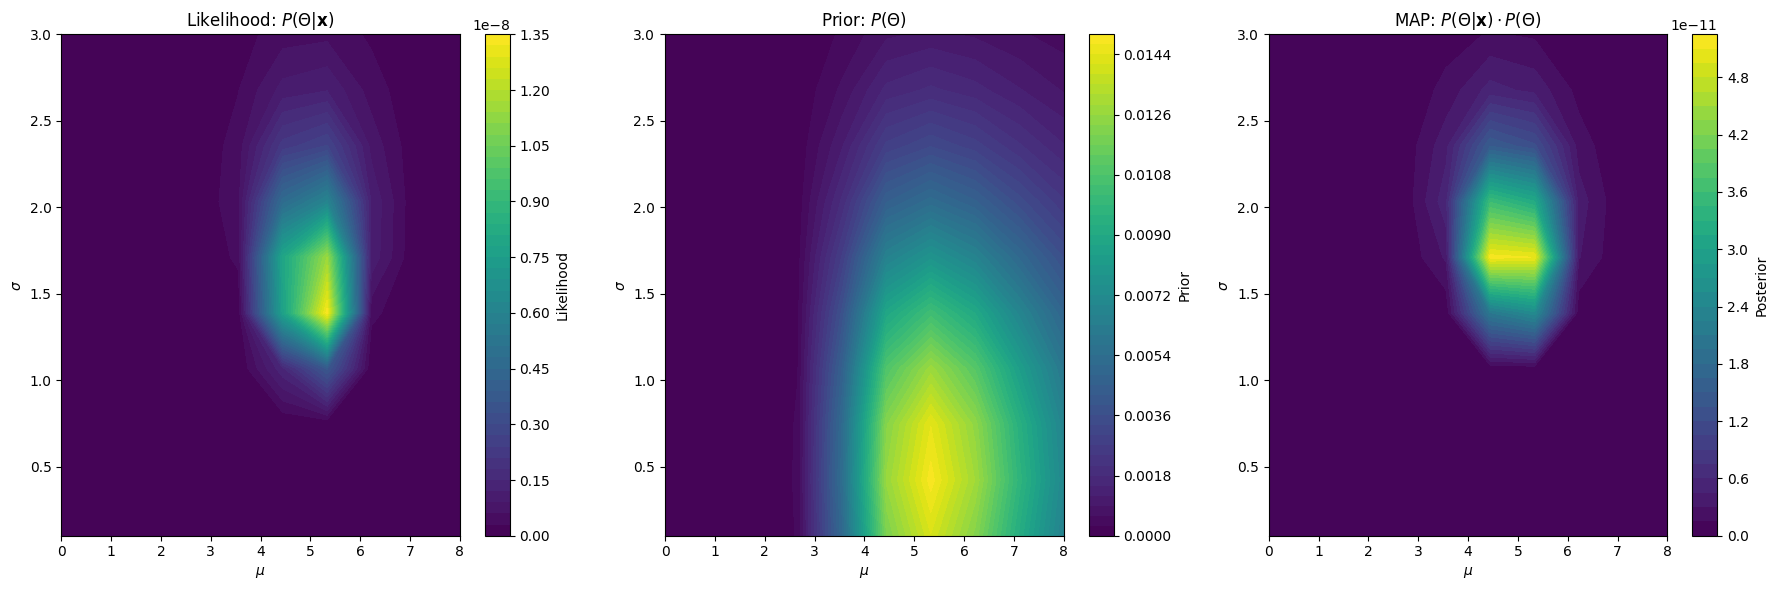

In [2]:
import jax.numpy as jnp
import jax.scipy as jscpy
from jax import random, vmap
import matplotlib.pyplot as plt
import jax.scipy.special as jsp

# Define the likelihood function
def likelihood(mu, sigma, data):
    """
    Calculate the likelihood of the data given mu and sigma for a normal distribution.

    Parameters:
    mu (float): Mean of the normal distribution.
    sigma (float): Standard deviation of the normal distribution.
    data (jnp.ndarray): Array of data points.

    Returns:
    float: likelihood value.
    """
    return jnp.prod(jscpy.stats.norm.pdf(data, mu, sigma))

# Define the inverse gamma PDF
def invgamma_pdf(x, alpha, beta):
    """
    Inverse gamma probability density function.

    Parameters:
    x (float): The random variable.
    alpha (float): Shape parameter of the inverse gamma distribution.
    beta (float): Scale parameter of the inverse gamma distribution.

    Returns:
    float: Probability density function value.
    """
    return (beta**alpha / jsp.gamma(alpha)) * (x**(-alpha-1)) * jnp.exp(-beta / x)

# Prior distribution functions
def prior_mu(mu, mu0=1, sigma0=3):
    """
    Prior distribution for mu.

    Parameters:
    mu (float): Mean of the normal distribution.
    mu0 (float): Prior mean.
    sigma0 (float): Prior standard deviation.

    Returns:
    float: Prior probability density.
    """
    return jscpy.stats.norm.pdf(mu, loc=mu0, scale=sigma0)

def prior_sigma(sigma, alpha=2, beta=12):
    """
    Prior distribution for sigma using the inverse gamma distribution.

    Parameters:
    sigma (float): Standard deviation of the normal distribution.
    alpha (float): Shape parameter of the inverse gamma distribution.
    beta (float): Scale parameter of the inverse gamma distribution.

    Returns:
    float: Prior probability density.
    """
    return invgamma_pdf(sigma**2, alpha, beta)

# Compute the posterior distribution
def posterior(mu, sigma, data):
    """
    Compute the posterior distribution.

    Parameters:
    mu (float): Mean of the normal distribution.
    sigma (float): Standard deviation of the normal distribution.
    data (jnp.ndarray): Array of data points.

    Returns:
    float: Posterior probability.
    """
    return likelihood(mu, sigma, data) * prior_mu(mu) * prior_sigma(sigma)

# Set random seed
key = random.PRNGKey(42)

# Generate sample data
mu_true, sigma_true = 5, 2
data = random.normal(key, shape=(10,)) * sigma_true + mu_true
n = data.size

# Generate values for mu and sigma
SAMPLES = 10
mu_values = jnp.linspace(0, 8, SAMPLES)
sigma_values = jnp.linspace(0.1, 3, SAMPLES)

# Vectorize the functions
vectorized_likelihood   = vmap(vmap(lambda mu, sigma: likelihood(mu, sigma, data), in_axes=(None, 0)), in_axes=(0, None))
vectorized_prior_mu     = vmap(prior_mu, in_axes=(0,))
vectorized_prior_sigma  = vmap(prior_sigma, in_axes=(0,))
vectorized_posterior    = vmap(vmap(lambda mu, sigma: posterior(mu, sigma, data), in_axes=(None, 0)), in_axes=(0, None))

# Compute values over the grid
mu_grid, sigma_grid = jnp.meshgrid(mu_values, sigma_values)
likelihood_values   = vectorized_likelihood(mu_values, sigma_values)
prior_mu_values     = vectorized_prior_mu(mu_grid.flatten()).reshape(mu_grid.shape)
prior_sigma_values  = vectorized_prior_sigma(sigma_grid.flatten()).reshape(sigma_grid.shape)
prior_values        = prior_mu_values * prior_sigma_values
posterior_values    = vectorized_posterior(mu_values, sigma_values)

# Ensure values are finite
likelihood_values = jnp.where(jnp.isfinite(likelihood_values), likelihood_values, -jnp.inf)
prior_values      = jnp.where(jnp.isfinite(prior_values), prior_values, -jnp.inf)
posterior_values  = jnp.where(jnp.isfinite(posterior_values), posterior_values, -jnp.inf)

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(18, 6), dpi=100)

# Likelihood plot
contour1 = axes[0].contourf(mu_values, sigma_values, likelihood_values.T, levels=50, cmap='viridis')
axes[0].set_xlabel('$\mu$')
axes[0].set_ylabel('$\sigma$')
axes[0].set_title('Likelihood: $P(\Theta|\mathbf{x})$')
fig.colorbar(contour1, ax=axes[0], label='Likelihood')

# Prior plot
contour2 = axes[1].contourf(mu_values, sigma_values, prior_values.T, levels=50, cmap='viridis')
axes[1].set_xlabel('$\mu$')
axes[1].set_ylabel('$\sigma$')
axes[1].set_title('Prior: $P(\Theta)$')
fig.colorbar(contour2, ax=axes[1], label='Prior')

# Posterior plot
contour3 = axes[2].contourf(mu_values, sigma_values, posterior_values.T, levels=50, cmap='viridis')
axes[2].set_xlabel('$\mu$')
axes[2].set_ylabel('$\sigma$')
axes[2].set_title('MAP: $P(\Theta|\mathbf{x})\cdot P(\Theta)$')
fig.colorbar(contour3, ax=axes[2], label='Posterior')

plt.tight_layout()
plt.show()


## Maximum A Posteriori (MAP) Estimation

In this section, we will demonstrate how to perform Maximum A Posteriori (MAP) estimation using a practical example. The goal is to estimate the parameters of a normal distribution, namely the mean ($\mu$) and the standard deviation ($\sigma$), given some observed data. MAP estimation combines both the likelihood of the observed data and our prior beliefs about the parameters.

### Data Generation

First, we generate sample data from a normal distribution with a known mean ($\mu_{\text{true}}$) and standard deviation ($\sigma_{\text{true}}$) to simulate observed data. This is done using the following equation:

$$
x_i = \mu_{\text{true}} + \sigma_{\text{true}}^2 \cdot Z_i
$$

where $Z_i \sim \mathcal{N}(0, 1)$ (standard normal distribution).

### Likelihood Function

The likelihood function represents the probability of the observed data given the parameters $\mu$ and $\sigma$. The probability density function (PDF) of the normal distribution is:

$$
f(x \mid \mu, \sigma) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(x - \mu)^2}{2\sigma^2}\right)
$$

The likelihood of the data is the product of the individual probabilities:

$$
\mathscr{L}(\mu, \sigma \mid \mathbf{x}) = \prod_{i=1}^{n} f(x_i \mid \mu, \sigma)
$$

### Prior Distributions

The prior distribution reflects our beliefs about the parameters $\mu$ and $\sigma$ before observing the data.

#### Prior for $\mu$

For the mean $\mu$, we use a normal prior:

$$
\mu \sim \mathcal{N}(\mu_0, \sigma_0^2)
$$

The probability density function of this prior is:

$$
P(\mu) = \frac{1}{\sqrt{2\pi\sigma_0^2}} \exp\left(-\frac{(\mu - \mu_0)^2}{2\sigma_0^2}\right)
$$

#### Prior for $\sigma$

For the standard deviation $\sigma$, we use an inverse gamma distribution for the variance $\sigma^2$:

$$
\sigma^2 \sim \text{Inv-Gamma}(\alpha, \beta)
$$

The probability density function of the inverse gamma distribution is:

$$
P(\sigma^2) = \frac{\beta^\alpha}{\Gamma(\alpha)} (\sigma^2)^{-\alpha-1} \exp\left(-\frac{\beta}{\sigma^2}\right)
$$

## Posterior Distribution

The posterior distribution combines the likelihood and the priors using Bayes' Theorem:

$$
P(\mu, \sigma \mid \mathbf{x}) \propto\mathscr{L}(\mu, \sigma \mid \mathbf{x}) P(\mu) P(\sigma)
$$

Substituting the likelihood and priors, the posterior is:

$$
P(\mu, \sigma \mid \mathbf{x}) \propto \left( \prod_{i=1}^{n} \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(x_i - \mu)^2}{2\sigma^2}\right) \right) \cdot \frac{1}{\sqrt{2\pi\sigma_0^2}} \exp\left(-\frac{(\mu - \mu_0)^2}{2\sigma_0^2}\right) \cdot \frac{\beta^\alpha}{\Gamma(\alpha)} (\sigma^2)^{-\alpha-1} \exp\left(-\frac{\beta}{\sigma^2}\right)
$$

## MAP Estimation

MAP estimation involves finding the parameters $\mu$ and $\sigma$ that maximize the posterior distribution:

$$
(\mu_{\text{MAP}}, \sigma_{\text{MAP}}) = \arg\max_{\mu, \sigma} P(\mu, \sigma \mid \mathbf{x})
$$

By maximizing the posterior, we incorporate both the observed data (through the likelihood) and our prior beliefs about the parameters. This provides a robust estimation method that is particularly useful when the data is scarce or when prior knowledge is strong.

## Summary

In this example, we have shown how to generate data, define the likelihood and prior distributions, and compute the posterior distribution. MAP estimation leverages both the data and prior knowledge to estimate the parameters of a normal distribution, providing a comprehensive approach to parameter estimation in a probabilistic framework.
